## Feature Engineeering

### 0) Notebook setup

In [17]:
# ============================================================================
# Task 4 — Feature Engineering
# Goal: Engineer predictive features (esp. price dynamics) for churn modeling
# Source files:
#   - clean_data_after_eda.csv     (row-level client data)
#   - price_data.csv               (or price_data (1).csv) time series of prices
# Outputs:
#   - outputs/clean_data_with_features.csv
#   - outputs/feature_dictionary.csv
#   - outputs/modeling_columns.txt
#   - figures_bcgx/*   (plots)
#   
# ============================================================================



import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Plot style
%matplotlib inline
sns.set(style="whitegrid", context="notebook")

# Create folders for artifacts
FIG_DIR = Path("figures_bcgx"); FIG_DIR.mkdir(exist_ok=True)
OUT_DIR = Path("outputs");       OUT_DIR.mkdir(exist_ok=True)

### 1) Load data + basic info

In [18]:
# ----------------------------------------------------------------------------
# 1. LOAD DATA
# ----------------------------------------------------------------------------
# Tip: Make sure the CSVs are in the same directory as this notebook.
# If your price file is named 'price_data (1).csv', set PRICE_FILE accordingly.

CLEAN_FILE = "clean_data_after_eda.csv"
PRICE_FILE_CANDIDATES = ["price_data.csv", "price_data (1).csv"]

df = pd.read_csv(CLEAN_FILE)
for c in ["date_activ", "date_end", "date_modif_prod", "date_renewal"]:
    df[c] = pd.to_datetime(df[c], format="%Y-%m-%d", errors="coerce")

print("[OK] Loaded:", CLEAN_FILE)
print("Shape:", df.shape)
display(df.head(3))

# Info snapshot
print("\nInfo:")
df.info()

# Pick the first existing price file
price_file = None
for cand in PRICE_FILE_CANDIDATES:
    if Path(cand).exists():
        price_file = cand
        break

if not price_file:
    raise FileNotFoundError("price_data.csv not found. Place price_data.csv (or price_data (1).csv) next to this notebook.")

print(f"\n[OK] Using price time-series file: {price_file}")

[OK] Loaded: clean_data_after_eda.csv
Shape: (14606, 44)


,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         


### 2) Light column triage

In [19]:
# ----------------------------------------------------------------------------
# 2. LIGHT TRIAGE: remove zero-variance / ID-like / obviously irrelevant cols
# ----------------------------------------------------------------------------
# (We keep this conservative; main removals happen after correlation review.)
drop_candidates = []  # e.g., ['some_always_constant_column']

existing_drops = [c for c in drop_candidates if c in df.columns]
df.drop(columns=existing_drops, inplace=True)
print(f"Columns dropped: {len(existing_drops)}")
print("New shape:", df.shape)

Columns dropped: 0
New shape: (14606, 44)


### 3) Estelle’s feature: Dec → Jan off-peak price deltas (robust)

In [20]:
# ----------------------------------------------------------------------------
# 3. ESTELLE'S FEATURE: Δ(Dec - Jan) for off-peak prices, per id, latest year
# ----------------------------------------------------------------------------
# Why robust? Datasets may span multiple years or be unsorted; first()/last()
# can miss Jan/Dec. We compute per (id, year) and then keep the latest year
# that has BOTH January and December.

prices = pd.read_csv(price_file)
prices["price_date"] = pd.to_datetime(prices["price_date"], errors="coerce")
prices["year"] = prices["price_date"].dt.year
prices["month"] = prices["price_date"].dt.month

# Keep only required columns
keep = [
    "id", "price_date", "year", "month",
    "price_off_peak_var", "price_off_peak_fix",
    "price_mid_peak_var", "price_peak_var",
    "price_mid_peak_fix", "price_peak_fix",
]
prices = prices[keep].copy()

# Helper: last record in each (id, year, month)
monthly = (prices.sort_values(["id", "year", "month", "price_date"])
                 .groupby(["id", "year", "month"], as_index=False)
                 .last())

# Latest Jan and Dec rows within each (id, year)
jan = (monthly.loc[monthly["month"] == 1, ["id", "year", "price_off_peak_var", "price_off_peak_fix"]]
              .rename(columns={"price_off_peak_var": "jan_offpeak_var",
                               "price_off_peak_fix": "jan_offpeak_fix"}))

dec = (monthly.loc[monthly["month"] == 12, ["id", "year", "price_off_peak_var", "price_off_peak_fix"]]
              .rename(columns={"price_off_peak_var": "dec_offpeak_var",
                               "price_off_peak_fix": "dec_offpeak_fix"}))

dj = (dec.merge(jan, on=["id", "year"], how="inner")
         .assign(
             delta_dec_jan_offpeak_var=lambda d: d["dec_offpeak_var"] - d["jan_offpeak_var"],
             delta_dec_jan_offpeak_fix=lambda d: d["dec_offpeak_fix"] - d["jan_offpeak_fix"]
         ))

# If multiple years per id, take latest year that has both months
dj_latest = (dj.sort_values(["id", "year"])
               .groupby("id", as_index=False)
               .last()[["id", "delta_dec_jan_offpeak_var", "delta_dec_jan_offpeak_fix"]])

# Merge into main df
df = df.merge(dj_latest, on="id", how="left")
print("[OK] Added Estelle’s Dec→Jan deltas.")
display(df[["delta_dec_jan_offpeak_var", "delta_dec_jan_offpeak_fix"]].head())

[OK] Added Estelle’s Dec→Jan deltas.


,delta_dec_jan_offpeak_var,delta_dec_jan_offpeak_fix
0,0.020057,3.700961
1,-0.003767,0.177779
2,-0.004670,0.177779
3,-0.004547,0.177779
4,-0.006192,0.162916


### 4) Inter-period price features (means)

In [21]:
# ----------------------------------------------------------------------------
# 4. MEAN PRICE DIFFERENCES ACROSS PERIODS (by company)
# ----------------------------------------------------------------------------
period_means = (prices.groupby("id", as_index=False)
                      .agg({
                          "price_off_peak_var": "mean",
                          "price_peak_var": "mean",
                          "price_mid_peak_var": "mean",
                          "price_off_peak_fix": "mean",
                          "price_peak_fix": "mean",
                          "price_mid_peak_fix": "mean"
                      }))

# Mean differences (var + fix)
period_means["off_peak_peak_var_mean_diff"]  = period_means["price_off_peak_var"] - period_means["price_peak_var"]
period_means["peak_mid_peak_var_mean_diff"]  = period_means["price_peak_var"]     - period_means["price_mid_peak_var"]
period_means["off_peak_mid_peak_var_mean_diff"] = period_means["price_off_peak_var"] - period_means["price_mid_peak_var"]

period_means["off_peak_peak_fix_mean_diff"]  = period_means["price_off_peak_fix"] - period_means["price_peak_fix"]
period_means["peak_mid_peak_fix_mean_diff"]  = period_means["price_peak_fix"]     - period_means["price_mid_peak_fix"]
period_means["off_peak_mid_peak_fix_mean_diff"] = period_means["price_off_peak_fix"] - period_means["price_mid_peak_fix"]

keep_cols = [
    "id",
    "off_peak_peak_var_mean_diff", "peak_mid_peak_var_mean_diff", "off_peak_mid_peak_var_mean_diff",
    "off_peak_peak_fix_mean_diff", "peak_mid_peak_fix_mean_diff", "off_peak_mid_peak_fix_mean_diff"
]
df = df.merge(period_means[keep_cols], on="id", how="left")
print("[OK] Added mean period-difference features.")

[OK] Added mean period-difference features.


### 5) Inter-period price features (max monthly deltas)

In [22]:
# ----------------------------------------------------------------------------
# 5. MAX MONTHLY DIFFERENCES ACROSS PERIODS (by company)
# ----------------------------------------------------------------------------
# Compute mean-diffs per (id, month) and then take max across months
period_diffs_monthly = monthly.copy()

period_diffs_monthly["off_peak_peak_var_mean_diff"] = (
    period_diffs_monthly["price_off_peak_var"] - period_diffs_monthly["price_peak_var"]
)
period_diffs_monthly["peak_mid_peak_var_mean_diff"] = (
    period_diffs_monthly["price_peak_var"] - period_diffs_monthly["price_mid_peak_var"]
)
period_diffs_monthly["off_peak_mid_peak_var_mean_diff"] = (
    period_diffs_monthly["price_off_peak_var"] - period_diffs_monthly["price_mid_peak_var"]
)

period_diffs_monthly["off_peak_peak_fix_mean_diff"] = (
    period_diffs_monthly["price_off_peak_fix"] - period_diffs_monthly["price_peak_fix"]
)
period_diffs_monthly["peak_mid_peak_fix_mean_diff"] = (
    period_diffs_monthly["price_peak_fix"] - period_diffs_monthly["price_mid_peak_fix"]
)
period_diffs_monthly["off_peak_mid_peak_fix_mean_diff"] = (
    period_diffs_monthly["price_off_peak_fix"] - period_diffs_monthly["price_mid_peak_fix"]
)

max_across_months = (period_diffs_monthly.groupby("id", as_index=False)
                     .agg({
                         "off_peak_peak_var_mean_diff": "max",
                         "peak_mid_peak_var_mean_diff": "max",
                         "off_peak_mid_peak_var_mean_diff": "max",
                         "off_peak_peak_fix_mean_diff": "max",
                         "peak_mid_peak_fix_mean_diff": "max",
                         "off_peak_mid_peak_fix_mean_diff": "max"
                     })
                     .rename(columns={
                         "off_peak_peak_var_mean_diff": "off_peak_peak_var_max_monthly_diff",
                         "peak_mid_peak_var_mean_diff": "peak_mid_peak_var_max_monthly_diff",
                         "off_peak_mid_peak_var_mean_diff": "off_peak_mid_peak_var_max_monthly_diff",
                         "off_peak_peak_fix_mean_diff": "off_peak_peak_fix_max_monthly_diff",
                         "peak_mid_peak_fix_mean_diff": "peak_mid_peak_fix_max_monthly_diff",
                         "off_peak_mid_peak_fix_mean_diff": "off_peak_mid_peak_fix_max_monthly_diff"
                     }))

df = df.merge(max_across_months, on="id", how="left")
print("[OK] Added max-monthly period-difference features.")

[OK] Added max-monthly period-difference features.


### 6) Tenure + “months since/until” features (then drop raw dates)

In [23]:
# ----------------------------------------------------------------------------
# 6. DATE TRANSFORMS: tenure + months_* features, then drop raw dates
# ----------------------------------------------------------------------------
# Tenure (years) — integer division on day diff
df["tenure"] = ((df["date_end"] - df["date_activ"]).dt.days // 365).astype("Int64")

# Helper: whole-months difference between reference_date and a date column
def months_between(reference_date: datetime, s: pd.Series) -> pd.Series:
    s = pd.to_datetime(s)
    yd = reference_date.year  - s.dt.year
    md = reference_date.month - s.dt.month
    months = yd * 12 + md
    months -= (reference_date.day < s.dt.day).astype(int)
    return months

ref = datetime(2016, 1, 1)
df["months_activ"]       = months_between(ref, df["date_activ"])
df["months_to_end"]      = -months_between(ref, df["date_end"])           # until end
df["months_modif_prod"]  = months_between(ref, df["date_modif_prod"])
df["months_renewal"]     = months_between(ref, df["date_renewal"])

# Drop raw date columns after deriving features
date_cols = ["date_activ", "date_end", "date_modif_prod", "date_renewal"]
df.drop(columns=date_cols, inplace=True)

print("[OK] Added tenure + months_*; dropped raw date columns.")

[OK] Added tenure + months_*; dropped raw date columns.


### 7) Boolean + categorical transforms

In [24]:
# ----------------------------------------------------------------------------
# 7. BOOLEAN + CATEGORICAL ENCODING
# ----------------------------------------------------------------------------
# has_gas: convert to numeric 0/1
if df["has_gas"].dtype == "O":
    df["has_gas"] = df["has_gas"].replace({"t": 1, "f": 0}).astype("int8")

# One-hot encode 'channel_sales' & 'origin_up'; drop rare dummies (<100 rows)
cat_cols = ["channel_sales", "origin_up"]
min_count = 100

# Store counts to drop rare dummies after get_dummies
value_counts = {c: df[c].value_counts() for c in cat_cols}

df = pd.get_dummies(df, columns=cat_cols, prefix=cat_cols, dtype=int)

# Drop rare dummies
for c in value_counts:
    keep_vals = set(value_counts[c][value_counts[c] >= min_count].index.astype(str))
    dummy_cols = [d for d in df.columns if d.startswith(f"{c}_")]
    drop_cols = [d for d in dummy_cols if d.split(f"{c}_", 1)[1] not in keep_vals]
    if drop_cols:
        df.drop(columns=drop_cols, inplace=True)

print("[OK] Encoded categoricals and removed rare dummies.")

[OK] Encoded categoricals and removed rare dummies.


### 8) Address skew (log10) + visual checks

Before log transform:


,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


After log transform:


,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,4.223939,0.779244,2.264646,2.962177,1.784610,0.050918,1.517203,0.055766,0.020918,1.636058
std,0.884515,1.717071,1.769305,0.683592,1.584986,0.267388,0.571481,0.009438,0.020296,0.134237
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.754023,0.000000,0.000000,2.695477,0.000000,0.000000,1.235023,0.047796,0.000000,1.619163
50%,4.149727,0.000000,2.899547,3.046836,2.498311,0.000000,1.296555,0.058109,0.035085,1.656207
75%,4.610285,0.000000,3.529430,3.380716,3.242231,0.000000,2.120673,0.059316,0.040933,1.656207
max,6.792889,6.618528,5.887169,4.918575,5.243970,1.491362,2.778376,0.105157,0.077722,1.780075


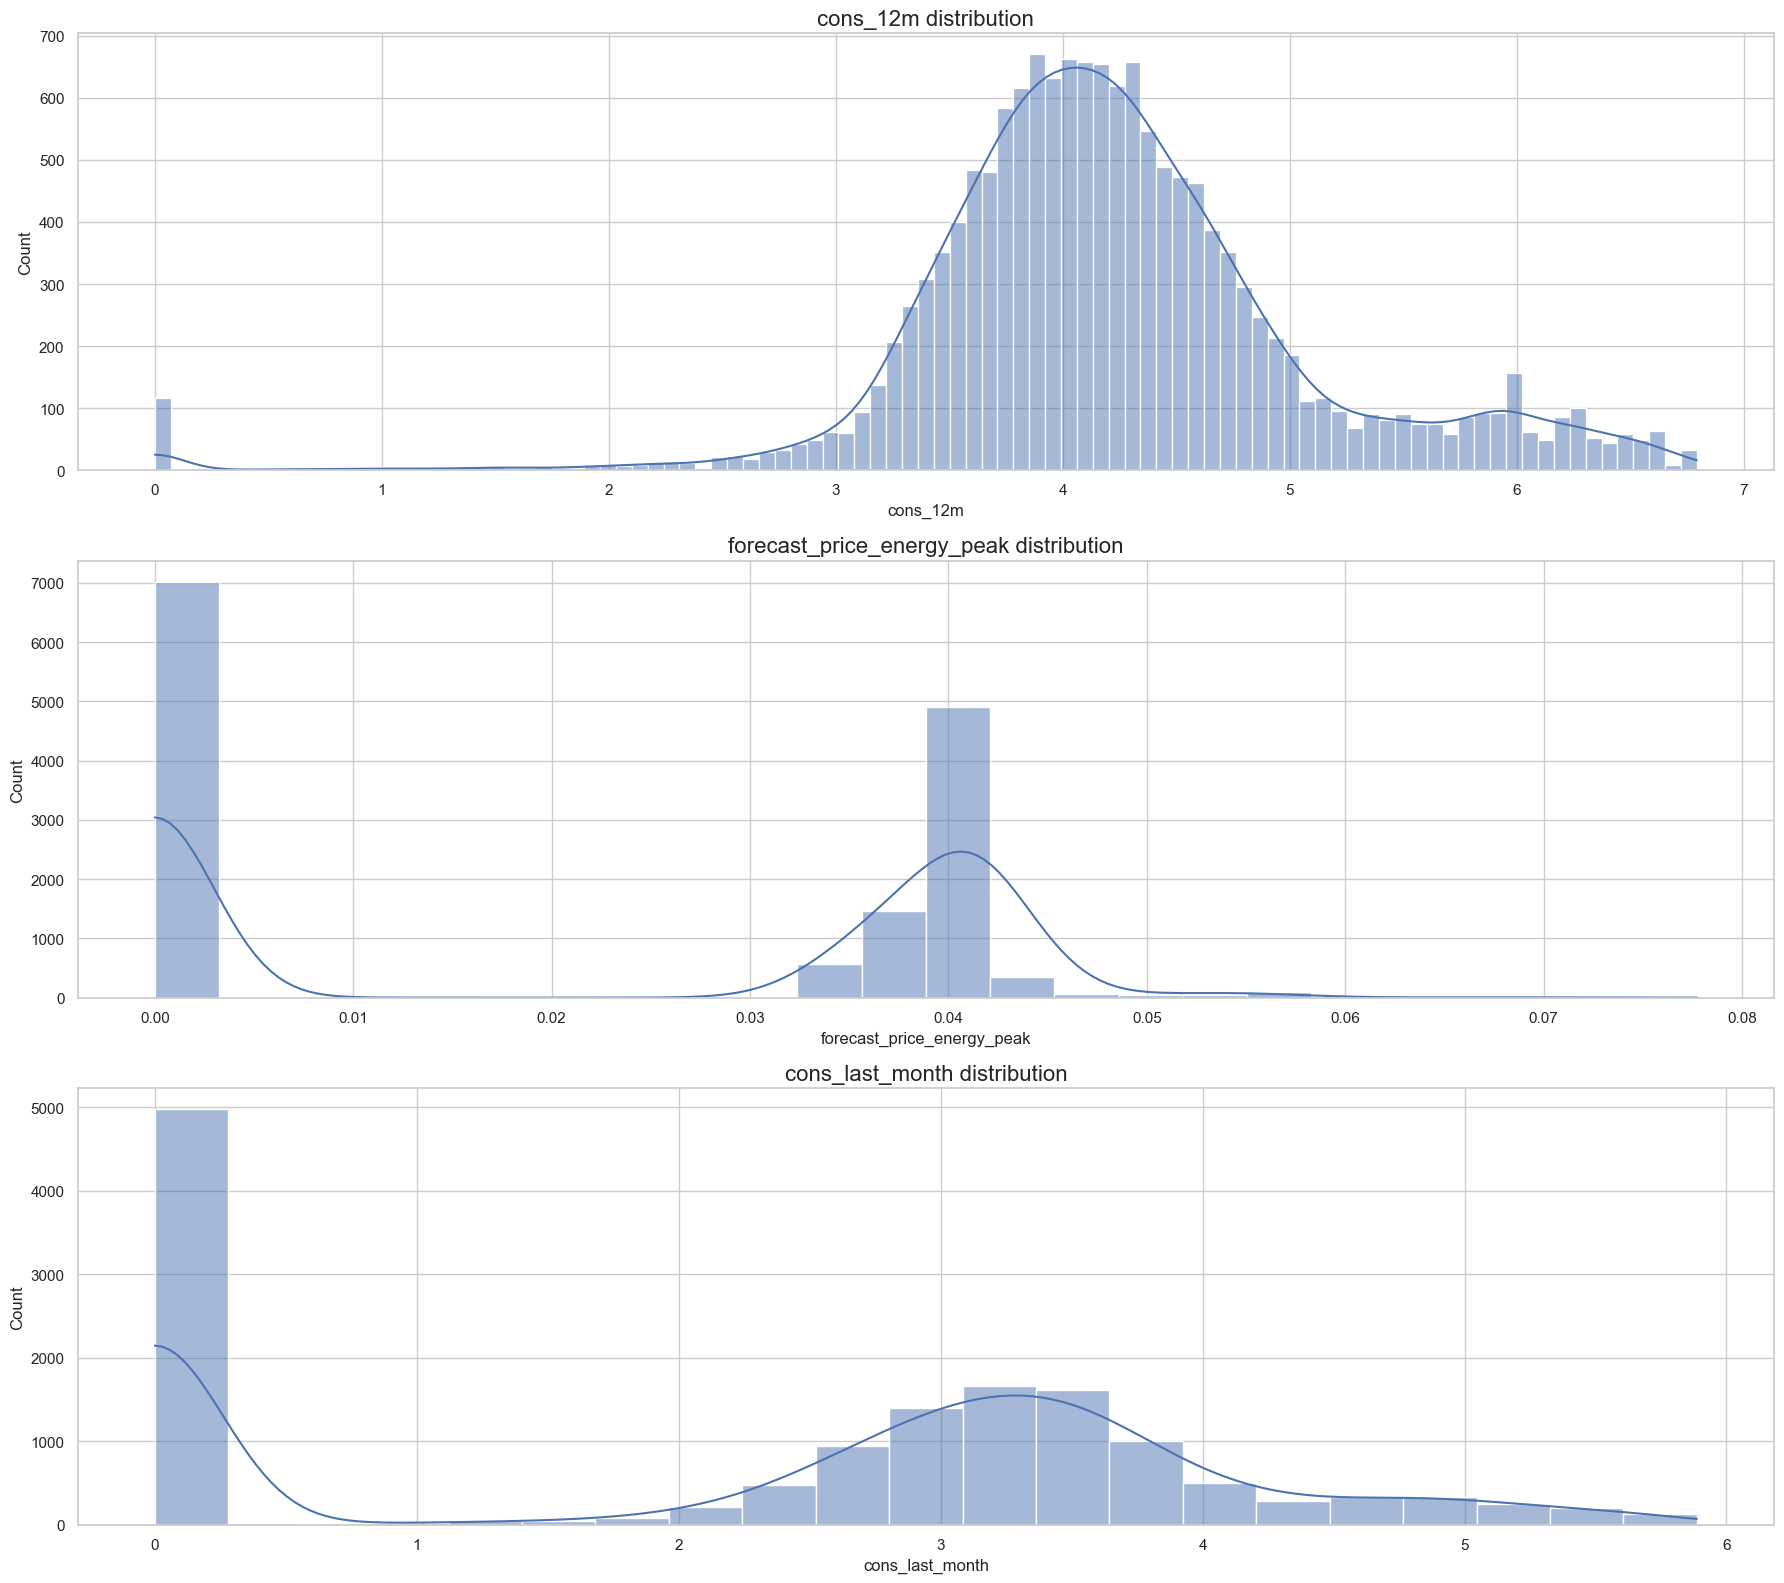

In [25]:
# ----------------------------------------------------------------------------
# 8. SKEW HANDLING: log10(x+1) for positively skewed continuous variables
# ----------------------------------------------------------------------------
# Same columns family as Example Answer (update if needed to match your file)
skewed_cols = [
    "cons_12m", "cons_gas_12m", "cons_last_month",
    "forecast_cons_12m", "forecast_cons_year",
    "forecast_discount_energy", "forecast_meter_rent_12m",
    "forecast_price_energy_off_peak", "forecast_price_energy_peak",
    "forecast_price_pow_off_peak"
]
skewed_cols = [c for c in skewed_cols if c in df.columns]

print("Before log transform:")
display(df[skewed_cols].describe())

df[skewed_cols] = np.log10(df[skewed_cols] + 1.0)

print("After log transform:")
display(df[skewed_cols].describe())

# Distribution visuals (as in the Example Answer)
plot_cols = [c for c in ["cons_12m", "forecast_price_energy_peak", "cons_last_month"] if c in df.columns]

fig, axes = plt.subplots(len(plot_cols), 1, figsize=(18, 16))
if len(plot_cols) == 1:
    axes = [axes]
for ax, col in zip(axes, plot_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=ax)
    ax.set_title(f"{col} distribution", fontsize=16)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "skew_transformed_distributions.png", dpi=150)
plt.show()

### 9) Correlation heatmap + light pruning

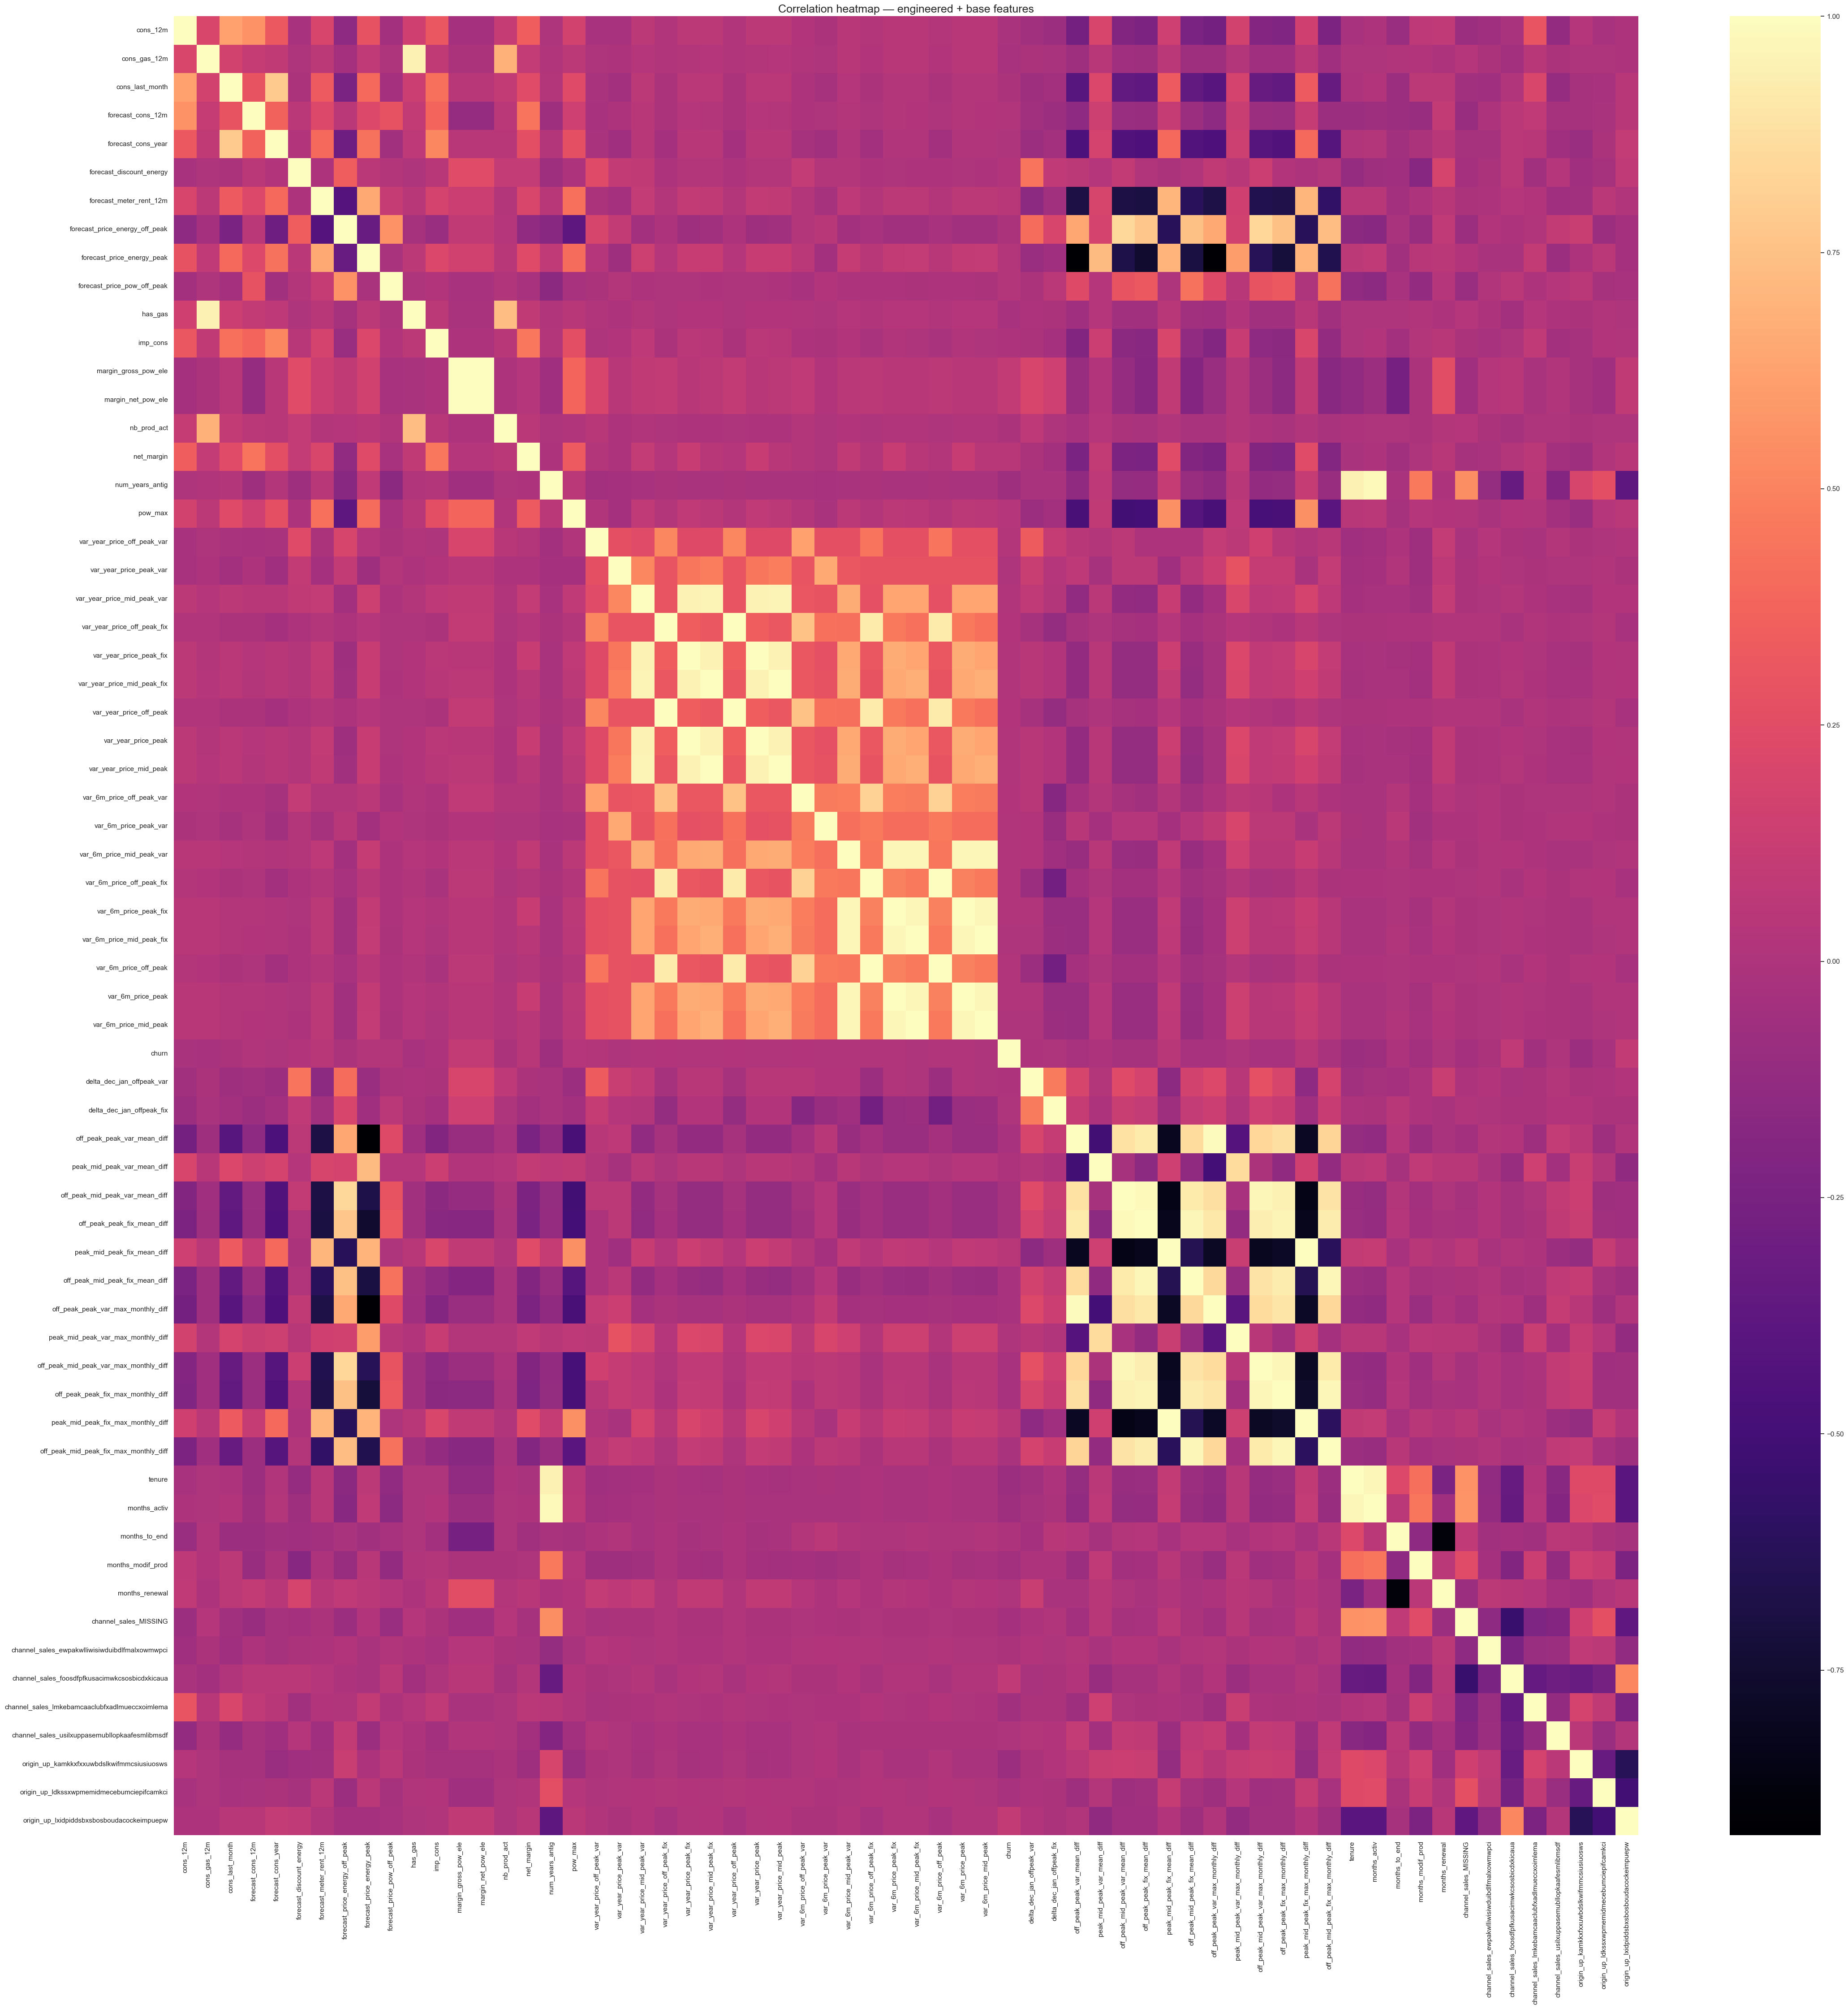

[OK] Dropped highly correlated example fields where present.


In [26]:
# ----------------------------------------------------------------------------
# 9. CORRELATIONS: inspect and drop a couple of highly collinear fields
# ----------------------------------------------------------------------------
corr_df = df.drop(columns=["id"], errors="ignore").select_dtypes(include=[np.number])
corr = corr_df.corr()

plt.figure(figsize=(45, 45))
sns.heatmap(
    corr, xticklabels=corr.columns, yticklabels=corr.columns,
    annot=False, cmap="magma"
)
plt.title("Correlation heatmap — engineered + base features", fontsize=18)
plt.tight_layout()
plt.savefig(FIG_DIR / "correlation_heatmap.png", dpi=150)
plt.show()

# Example Answer drops these two
for col in ["num_years_antig", "forecast_cons_year"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

print("[OK] Dropped highly correlated example fields where present.")

### 10) Quick QC: coverage, missingness, base churn rate

In [27]:
# ----------------------------------------------------------------------------
# 10. QUICK QC SNAPSHOT
# ----------------------------------------------------------------------------
qc_fields = [
    "delta_dec_jan_offpeak_var", "delta_dec_jan_offpeak_fix",
    "off_peak_peak_var_mean_diff", "off_peak_peak_fix_mean_diff",
    "off_peak_peak_var_max_monthly_diff", "off_peak_peak_fix_max_monthly_diff",
    "tenure", "months_activ", "months_to_end", "months_modif_prod", "months_renewal"
]
qc_fields = [c for c in qc_fields if c in df.columns]

coverage = (df[qc_fields].notna().mean().rename("coverage").to_frame())
missing  = (1 - df[qc_fields].notna().mean()).rename("missing_rate").to_frame()

print("Feature coverage (fraction non-null):")
display(coverage.sort_values("coverage"))

print("Missingness (engineered fields):")
display(missing.sort_values("missing_rate", ascending=False))

if "churn" in df.columns:
    churn_rate = df["churn"].mean()
    print(f"Churn base rate: {churn_rate:.3f}")

Feature coverage (fraction non-null):


,coverage
delta_dec_jan_offpeak_var,0.998494
delta_dec_jan_offpeak_fix,0.998494
off_peak_peak_var_mean_diff,1.000000
off_peak_peak_fix_mean_diff,1.000000
off_peak_peak_var_max_monthly_diff,1.000000
off_peak_peak_fix_max_monthly_diff,1.000000
tenure,1.000000
months_activ,1.000000
months_to_end,1.000000
months_modif_prod,1.000000


Missingness (engineered fields):


,missing_rate
delta_dec_jan_offpeak_var,0.001506
delta_dec_jan_offpeak_fix,0.001506
off_peak_peak_var_mean_diff,0.000000
off_peak_peak_fix_mean_diff,0.000000
off_peak_peak_var_max_monthly_diff,0.000000
off_peak_peak_fix_max_monthly_diff,0.000000
tenure,0.000000
months_activ,0.000000
months_to_end,0.000000
months_modif_prod,0.000000


Churn base rate: 0.097


### 11) Save outputs for modeling + simple feature dictionary

In [28]:
# ----------------------------------------------------------------------------
# 11. SAVE ARTIFACTS
# ----------------------------------------------------------------------------
save_cols = [c for c in df.columns]  # all engineered + base (id, churn kept)
df_out = df.copy()

out_csv = OUT_DIR / "clean_data_with_features.csv"
df_out.to_csv(out_csv, index=False)
print(f"[OK] Saved feature-enhanced dataset → {out_csv.resolve()}")

# Modeling columns: exclude id only (labels/features managed in modeling step)
modeling_cols = [c for c in df_out.columns if c != "id"]
with open(OUT_DIR / "modeling_columns.txt", "w") as f:
    f.write("\n".join(modeling_cols))
print("[OK] Saved modeling columns → outputs/modeling_columns.txt")

# Simple feature dictionary (name + short description)
feat_dict = []
def add_desc(name, desc):
    if name in df_out.columns:
        feat_dict.append((name, desc))

add_desc("delta_dec_jan_offpeak_var",  "Dec→Jan delta in off-peak variable price (latest year with both months)")
add_desc("delta_dec_jan_offpeak_fix",  "Dec→Jan delta in off-peak fixed price (latest year with both months)")
add_desc("off_peak_peak_var_mean_diff","Mean diff (off-peak VAR − peak VAR) across time series")
add_desc("off_peak_peak_fix_mean_diff","Mean diff (off-peak FIX − peak FIX) across time series")
add_desc("off_peak_peak_var_max_monthly_diff","Max monthly diff across periods (VAR)")
add_desc("off_peak_peak_fix_max_monthly_diff","Max monthly diff across periods (FIX)")
add_desc("tenure",                     "Tenure in years (floor)")
add_desc("months_activ",               "Months active at 2016-01-01")
add_desc("months_to_end",              "Months until contract end at 2016-01-01 (>=0)")
add_desc("months_modif_prod",          "Months since last product modification at 2016-01-01")
add_desc("months_renewal",             "Months since last renewal at 2016-01-01")

feat_df = pd.DataFrame(feat_dict, columns=["feature", "description"])
feat_df.to_csv(OUT_DIR / "feature_dictionary.csv", index=False)
print(f"[OK] Saved feature dictionary → { (OUT_DIR / 'feature_dictionary.csv').resolve() }")

print("\n================ FEATURE ENGINEERING SNAPSHOT ================")
print(f"Rows: {df_out.shape[0]} | Columns: {df_out.shape[1]}")
if "churn" in df_out.columns:
    print(f"Churn base rate: {df_out['churn'].mean():.3f}")
print("\nSample engineered fields:")
display(feat_df.head(10))
print(f"Figures: {FIG_DIR.resolve()}")
print(f"Outputs: {OUT_DIR.resolve()}")
print("==============================================================")

[OK] Saved feature-enhanced dataset → C:\Users\richa\outputs\clean_data_with_features.csv
[OK] Saved modeling columns → outputs/modeling_columns.txt
[OK] Saved feature dictionary → C:\Users\richa\outputs\feature_dictionary.csv

================ FEATURE ENGINEERING SNAPSHOT ================
Rows: 14606 | Columns: 63
Churn base rate: 0.097

Sample engineered fields:


,feature,description
0,delta_dec_jan_offpeak_var,Dec→Jan delta in off-peak variable price (late...
1,delta_dec_jan_offpeak_fix,Dec→Jan delta in off-peak fixed price (latest ...
2,off_peak_peak_var_mean_diff,Mean diff (off-peak VAR − peak VAR) across tim...
3,off_peak_peak_fix_mean_diff,Mean diff (off-peak FIX − peak FIX) across tim...
4,off_peak_peak_var_max_monthly_diff,Max monthly diff across periods (VAR)
5,off_peak_peak_fix_max_monthly_diff,Max monthly diff across periods (FIX)
6,tenure,Tenure in years (floor)
7,months_activ,Months active at 2016-01-01
8,months_to_end,Months until contract end at 2016-01-01 (>=0)
9,months_modif_prod,Months since last product modification at 2016...


Figures: C:\Users\richa\figures_bcgx
Outputs: C:\Users\richa\outputs


### Sanity Checks

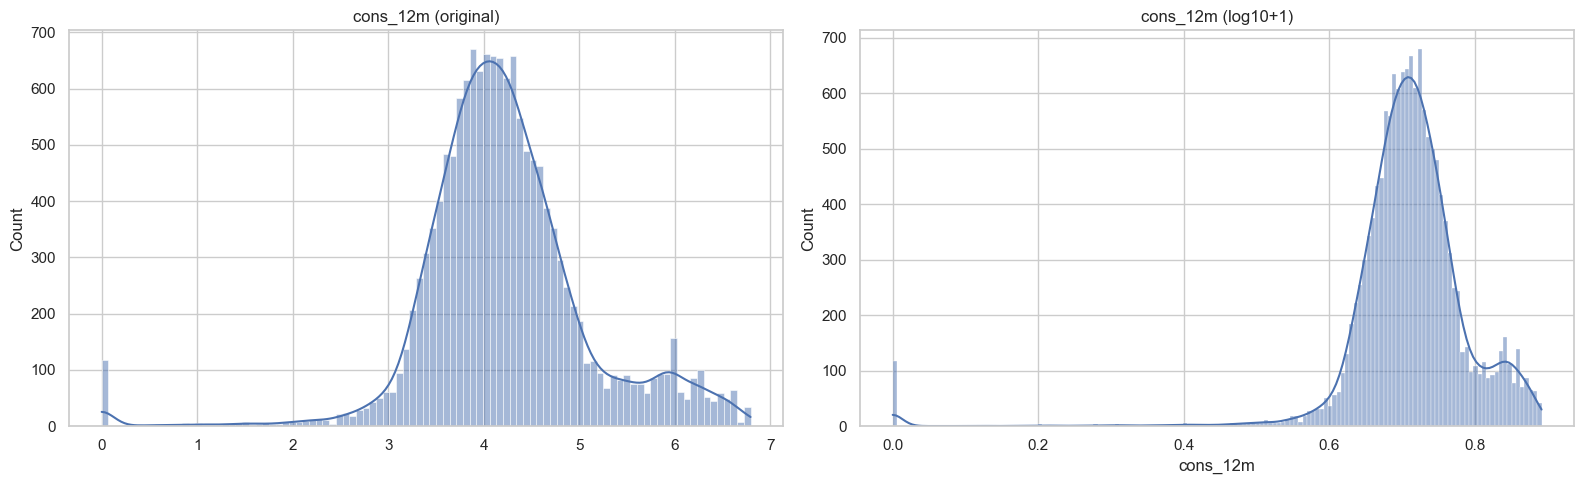

In [29]:
# --- before vs after visuals for one feature ---
feat = "cons_12m"
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(np.log10(df[feat] + 1.0), kde=True, ax=ax[1])
ax[1].set_title(f"{feat} (log10+1)")
sns.histplot(np.where(df[feat] < 0, np.nan, df[feat]), kde=True, ax=ax[0])
ax[0].set_title(f"{feat} (original)")
for a in ax: a.set_ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / f"{feat}_before_after_log.png", dpi=150)
plt.show()

# --- exact-example alias names for Dec→Jan features ---
rename_map = {
    "delta_dec_jan_offpeak_var": "offpeak_diff_dec_january_energy",
    "delta_dec_jan_offpeak_fix": "offpeak_diff_dec_january_power",
}
df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

In [30]:
from scipy.stats import pointbiserialr

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != "churn"]
corrs = []
for c in num_cols:
    vals = df[[c, "churn"]].dropna()
    if len(vals) > 10:
        r, p = pointbiserialr(vals["churn"], vals[c])
        corrs.append((c, r, p, len(vals)))
pd.DataFrame(corrs, columns=["feature","r_pb","p_value","n"])\
  .sort_values("r_pb", ascending=False)\
  .head(20)

,feature,r_pb,p_value,n
12,margin_net_pow_ele,0.095772,4.111908e-31,14606
11,margin_gross_pow_ele,0.095725,4.392533e-31,14606
60,origin_up_lxidpiddsbxsbosboudacockeimpuepw,0.094131,4.155264e-30,14606
55,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,0.075964,3.815847e-20,14606
40,peak_mid_peak_fix_mean_diff,0.045879,2.902607e-08,14606
46,peak_mid_peak_fix_max_monthly_diff,0.045795,3.076953e-08,14606
14,net_margin,0.041135,6.591893e-07,14606
5,forecast_meter_rent_12m,0.038964,2.472178e-06,14606
15,pow_max,0.030362,2.426324e-04,14606
7,forecast_price_energy_peak,0.029070,4.418404e-04,14606
